In [2]:
import requests
import pandas as pd

# Vellore coordinates
lat, lon = 12.9165, 79.1325

# API endpoint (Open-Meteo)
url = (
    f"https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={lat}&longitude={lon}"
    f"&start_date=2019-01-01&end_date=2024-12-31"
    f"&monthly=temperature_2m_mean,relative_humidity_2m_mean"
    f"&timezone=auto"
)

# Fetch data
response = requests.get(url)
data = response.json()

# Check keys returned
print("Keys in response:", data.keys())

# Build DataFrame safely
if "monthly" in data:
    monthly = data["monthly"]
    df = pd.DataFrame({
        "date": monthly["time"],
        "temperature_2m_mean": monthly["temperature_2m_mean"],
        "relative_humidity_2m_mean": monthly["relative_humidity_2m_mean"]
    })
    
    # Save to CSV
    df.to_csv("vellore_weather_2019_2024.csv", index=False)
    print(df.head())
else:
    print("Error in API response:", data)


Keys in response: dict_keys(['latitude', 'longitude', 'generationtime_ms', 'utc_offset_seconds', 'timezone', 'timezone_abbreviation', 'elevation'])
Error in API response: {'latitude': 12.899824, 'longitude': 79.12806, 'generationtime_ms': 0.006079673767089844, 'utc_offset_seconds': 19800, 'timezone': 'Asia/Kolkata', 'timezone_abbreviation': 'GMT+5:30', 'elevation': 218.0}


     date    T2M   RH2M
0  201901  22.42  72.11
1  201902  26.94  62.87
2  201903  29.90  53.04
3  201904  31.88  51.69
4  201905  32.87  53.60


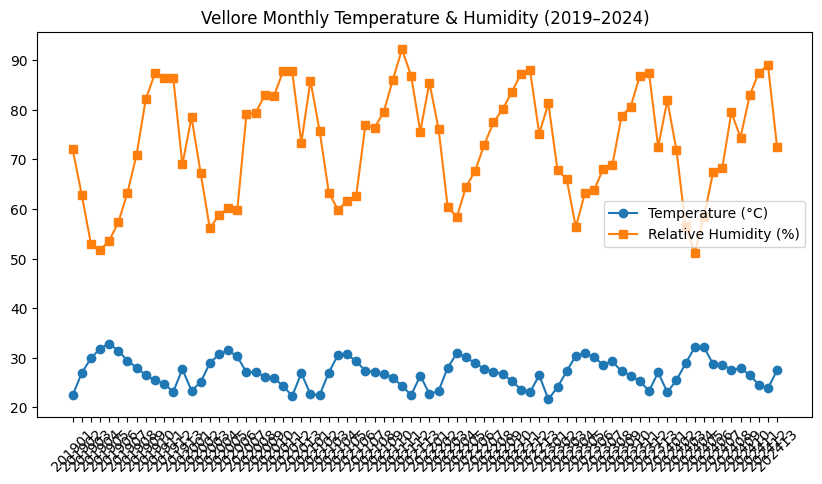

In [4]:
import requests
import pandas as pd

# Vellore coordinates
lat, lon = 12.9165, 79.1325

# NASA POWER API for monthly temperature & humidity
url = (
    f"https://power.larc.nasa.gov/api/temporal/monthly/point"
    f"?parameters=T2M,RH2M"
    f"&community=AG"
    f"&longitude={lon}&latitude={lat}"
    f"&start=2019&end=2024"
    f"&format=JSON"
)

# Fetch data
response = requests.get(url)
data = response.json()

# Extract parameters
params = data["properties"]["parameter"]

# Build dataframe
df = pd.DataFrame({
    "date": list(params["T2M"].keys()),
    "T2M": list(params["T2M"].values()),
    "RH2M": list(params["RH2M"].values())
})

# Save to CSV
df.to_csv("vellore_weather_2019_2024.csv", index=False)

print(df.head())

# Optional plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(df["date"], df["T2M"], label="Temperature (°C)", marker="o")
plt.plot(df["date"], df["RH2M"], label="Relative Humidity (%)", marker="s")
plt.xticks(rotation=45)
plt.legend()
plt.title("Vellore Monthly Temperature & Humidity (2019–2024)")
plt.show()


In [6]:
import geopandas as gpd
import requests
import pandas as pd
from tqdm import tqdm

# Step 1: Load shapefile/GeoJSON for Vellore
# (GeoJSON or shapefile)
gdf = gpd.read_file(r"D:\7TH SEMESTER\Adv_Predictive_Analytics\Project_Docs\Vellore Shapefile\Vellore_boundary.shp")

# Step 2: Compute centroids
gdf["centroid"] = gdf.geometry.centroid
gdf["lon"] = gdf.centroid.x
gdf["lat"] = gdf.centroid.y

# Prepare final dataframe
all_data = []

# Step 3: Loop over each polygon centroid
for idx, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
    lat, lon = row["lat"], row["lon"]
    area_name = row["NAME_3"]  # change field name depending on shapefile (e.g. 'ward_name')
    
    # NASA POWER API call
    url = (
        f"https://power.larc.nasa.gov/api/temporal/monthly/point"
        f"?parameters=T2M,RH2M"
        f"&community=AG"
        f"&longitude={lon}&latitude={lat}"
        f"&start=2019&end=2024"
        f"&format=JSON"
    )
    
    response = requests.get(url)
    data = response.json()
    
    if "properties" in data:
        params = data["properties"]["parameter"]
        df = pd.DataFrame({
            "date": list(params["T2M"].keys()),
            "T2M": list(params["T2M"].values()),
            "RH2M": list(params["RH2M"].values())
        })
        df["area_name"] = area_name
        df["lat"] = lat
        df["lon"] = lon
        all_data.append(df)

# Step 4: Merge all into single dataframe
final_df = pd.concat(all_data, ignore_index=True)

# Save to CSV
final_df.to_csv("vellore_polygons_weather_2019_2024.csv", index=False)

print(final_df.head())


C:\Users\rufin\AppData\Local\Temp\ipykernel_12580\139750492.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["centroid"] = gdf.geometry.centroid
C:\Users\rufin\AppData\Local\Temp\ipykernel_12580\139750492.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.centroid.x
C:\Users\rufin\AppData\Local\Temp\ipykernel_12580\139750492.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.centroid.y
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:36<00:00,  5.26s/it]

     date    T2M   RH2M  area_name        lat        lon
0  201901  22.42  72.11  Arakkonam  13.012973  79.579807
1  201902  26.94  62.87  Arakkonam  13.012973  79.579807
2  201903  29.90  53.04  Arakkonam  13.012973  79.579807
3  201904  31.88  51.69  Arakkonam  13.012973  79.579807
4  201905  32.87  53.60  Arakkonam  13.012973  79.579807


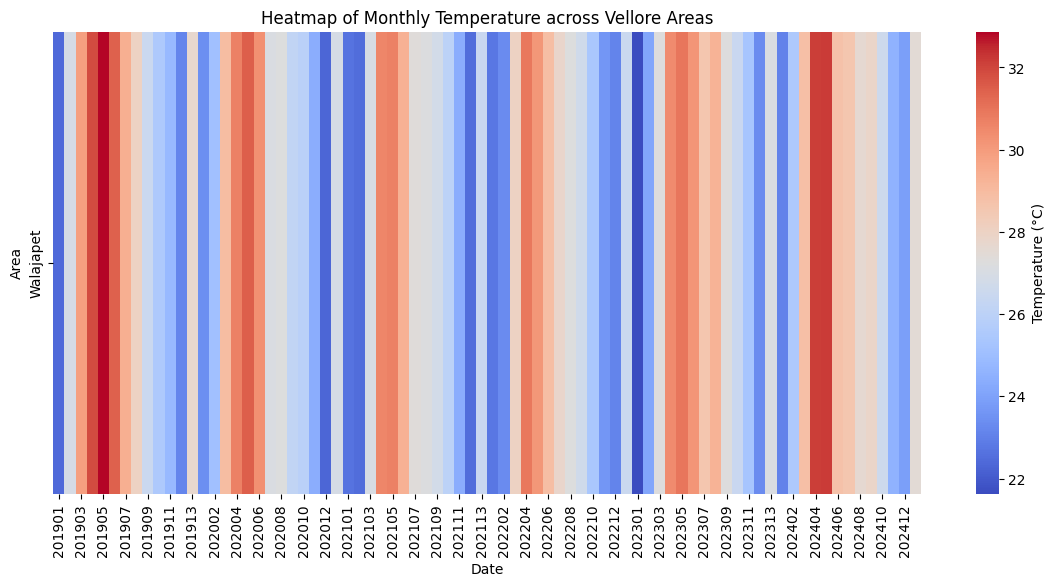

In [9]:
import seaborn as sns

pivot_temp = df.pivot(index="date", columns="area_name", values="T2M")
plt.figure(figsize=(14,6))
sns.heatmap(pivot_temp.T, cmap="coolwarm", cbar_kws={'label': 'Temperature (°C)'})
plt.title("Heatmap of Monthly Temperature across Vellore Areas")
plt.xlabel("Date")
plt.ylabel("Area")
plt.show()


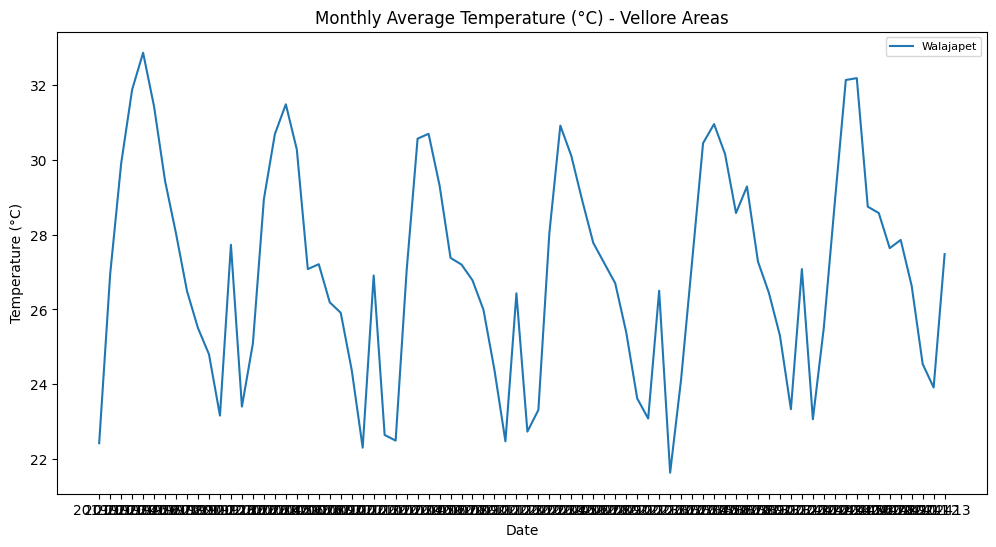

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for area in df["area_name"].unique():
    subset = df[df["area_name"] == area]
    plt.plot(subset["date"], subset["T2M"], label=area)

plt.title("Monthly Average Temperature (°C) - Vellore Areas")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend(loc="upper right", fontsize=8)
plt.show()


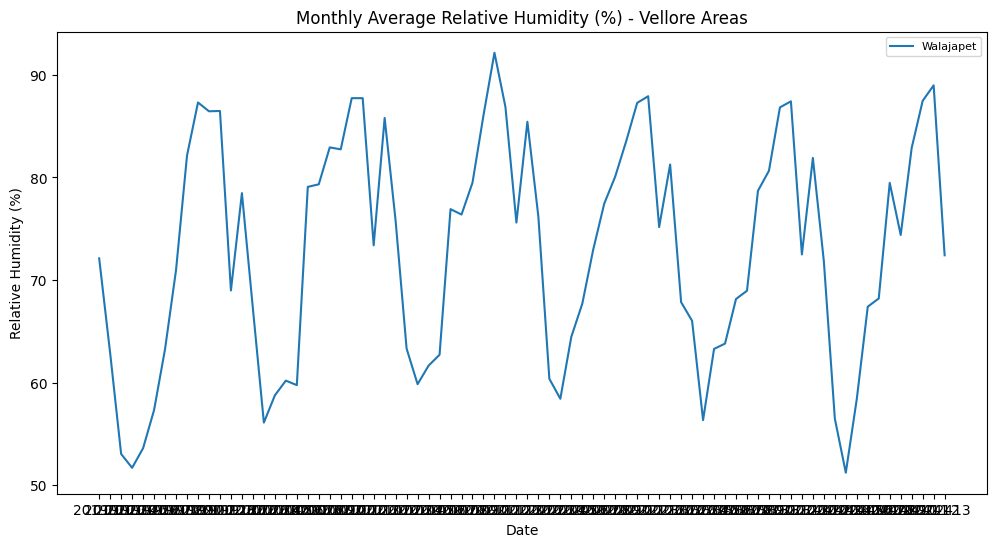

In [8]:
plt.figure(figsize=(12,6))
for area in df["area_name"].unique():
    subset = df[df["area_name"] == area]
    plt.plot(subset["date"], subset["RH2M"], label=area)

plt.title("Monthly Average Relative Humidity (%) - Vellore Areas")
plt.xlabel("Date")
plt.ylabel("Relative Humidity (%)")
plt.legend(loc="upper right", fontsize=8)
plt.show()


In [2]:
import sys
!{sys.executable} -m pip install geemap

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/631.5 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/631.5 kB ? eta -:--:--
   ---------------------------------------- 631.5/631.5 kB 2.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------- ----------------------- 0.5/1.2 MB 1.9 MB/s eta 0:00:01
   --------------------------------- ------ 1.0/1.2 MB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ------------------------ --------------- 0.8/1.3 MB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 3.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ------------------------- -------------- 0.8/1.2 MB 3.7 MB/s eta 0:00:01
   --------


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\rufin\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip
